In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
from scipy.ndimage.morphology import binary_fill_holes

%matplotlib inline

In [2]:
img_shape = (64,64)

In [3]:
def pad_resize(img):
    top = int((224 - img.shape[0])/2)
    left = int((224 - img.shape[1])/2)
    bottom = 224 - img.shape[0] - top
    right = 224 - img.shape[1] - left
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)
    img = img/255.
    img = cv2.resize(img, img_shape) #KADD
    return img

def skeletonize(img):
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)
    img = cv2.bitwise_not(img)
#     element = cv2.getStructuringElement(cv2.MORPH_CROSS,(1,1))
#     done = 0
#     while( done < 1 ):
#         eroded = cv2.erode(img,element)
#         temp = cv2.dilate(eroded,element)
#         temp = cv2.subtract(img,temp)
#         skel = cv2.bitwise_or(skel,temp)
#         img = eroded.copy()

#         zeros = size - cv2.countNonZero(img)
#         if zeros==size:#cv2.countNonZero(img) * 1 >= 0:#
#             done += 1
#     img = skel
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 2)
    img = cv2.bitwise_not(erosion)
    return img

In [4]:
PATH = '../train_images_modified'
images = []
base_class = []
matra_class = []
dot_class = []
total_class = []
for filename in os.listdir(PATH):
    if filename.endswith(".png"):
        img = cv2.imread(os.path.join(PATH,filename),0)
        blur = cv2.GaussianBlur(img,(9,9),0)# KADD
        a,img = cv2.threshold(blur,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)#KEDIT
#         kernel = np.ones((5,5),np.uint8)
#         img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
#         plt.imshow(img, cmap='gray')
#         plt.show()
#        img = skeletonize(img)
        img = pad_resize(img)
        blur = cv2.GaussianBlur(img,(9,9),0)# KADD
        char_arr = filename[:-4].split('_')[3:]
        if(len(char_arr)>0):
            char_arr = [int(i) for i in char_arr]
            base = [i for i in char_arr if (i>=2308 and i<=2361) or (i==2384) or (i>=2392 and i<=2401) or (i>=2404 and i!=2416 and i!=2417)]  
            matra = [i for i in char_arr if i>=2362 and i<=2391 and i!=2364 and i!=2362]
            dot = [i for i in char_arr if i==2306 or i==2416 or i==2362 or i==2364 or i==2417]
            if(len(matra)>1 or len(dot)>1 or len(base)>1 or (len(matra)==0 and len(dot)==0 and len(char_arr)==2)):
                print(filename+" dropped!")
            else:
                images.append(img)
                base_class.append(base[0])
                if(len(matra)==1):
                    matra_class.append(matra[0])
                else:
                    matra_class.append(0)

                if len(dot)==1:
                    if dot[0] == 2364 or dot[0] == 2416:
                        dot_class.append(2)
                    else:
                        dot_class.append(1)
                else:
                    dot_class.append(0)

                if len(images)%100==0:
                    print("{} Done".format(len(images)))
            

100 Done
page6_1_1_2340_2375_2379.png dropped!
200 Done
page7_3_0_2319_2366_2367.png dropped!
300 Done
page0_8_8_2330_2375_2379.png dropped!
400 Done
page6_10_6_2325_2366_2380.png dropped!
page0_9_15_2332_2375_2379.png dropped!
500 Done
600 Done
page3_19_7_2357_2364_2417.png dropped!
700 Done
page3_18_4_2332_2366_2379.png dropped!
page3_12_0_2357_2364_2416.png dropped!
800 Done
900 Done
page7_3_13_2319_2366_2367.png dropped!
1000 Done
1100 Done
1200 Done
1300 Done
1400 Done
page5_7_8_2325_2367_2388.png dropped!
1500 Done
page2_4_20_2346_2366_2390.png dropped!
1600 Done
1700 Done
1800 Done


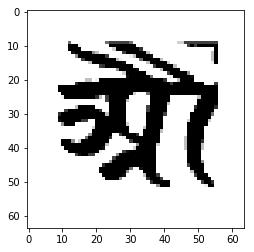

1884
1884


In [5]:
plt.imshow(images[10],"gray")
plt.show()
print(len(images))
print(len(dot_class))

In [6]:
len(set(base_class))
freq = {i:base_class.count(i) for i in base_class}
[i for i in freq.keys() if freq[i]==1]

[2392, 2353, 2384, 2415, 2310, 2414]

In [7]:
images = np.array(images)
print(images.shape)

(1884, 64, 64)


In [8]:
import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
le.fit(base_class)
y_labeled = le.transform(base_class)
y_train = np_utils.to_categorical(y_labeled)
print(y_train.shape)
#print(le)
#le.get_params()
#for i in range(len(topr)):
#    if base_class[i] == 2405:
#        print('{} {}'.format(topr[i], base_class[i]))

Using TensorFlow backend.


(1884, 53)


In [9]:
x_train = np.reshape(images,(-1,img_shape[0],img_shape[1],1))
print(x_train.shape)

(1884, 64, 64, 1)


In [10]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from keras.optimizers import Adam

base_model = Sequential()

base_model.add(Conv2D(16,(3,3),input_shape = (img_shape[0],img_shape[1],1),activation = 'relu'))
base_model.add(Conv2D(16,(3,3),activation = 'relu'))
base_model.add(MaxPooling2D())
base_model.add(Conv2D(32,(3,3),activation = 'relu'))
base_model.add(Conv2D(32,(3,3),activation = 'relu'))
base_model.add(MaxPooling2D())
base_model.add(Conv2D(64,(3,3),activation = 'relu'))
base_model.add(Conv2D(64,(3,3),activation = 'relu'))
base_model.add(MaxPooling2D())
base_model.add(MaxPooling2D())
base_model.add(Dropout(0.5))
base_model.add(Flatten())
base_model.add(Dense(256,activation = 'sigmoid'))
base_model.add(Dropout(0.25))
base_model.add(Dense(len(set(base_class)),activation = 'softmax'))

In [11]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
__________

In [12]:
import keras.backend as K

def f1_score(theta):
    def score(y_true, y_pred):

        y_thresh = K.cast(K.greater(y_pred,theta),K.floatx())

        true_pos =  K.sum(y_true * y_thresh)
        false_pos = K.sum(y_true * (1. - y_thresh))
        false_neg = K.sum((1. - y_true) * y_thresh)

        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        
        f1_score_val = 2 * (precision * recall) / (precision + recall)
        return f1_score_val
    return score

In [13]:
base_model.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [14]:
# augmentation code here ...

In [15]:
base_model.fit(x_train,y_train,epochs=30,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 566 samples
Epoch 1/30
1318/1318 [==============================] - 15s 12ms/step - loss: 3.5758 - categorical_accuracy: 0.0804 - val_loss: 3.3588 - val_categorical_accuracy: 0.1166
Epoch 2/30
1318/1318 [==============================] - 15s 11ms/step - loss: 3.4012 - categorical_accuracy: 0.0751 - val_loss: 3.3592 - val_categorical_accuracy: 0.1166
Epoch 3/30
1318/1318 [==============================] - 15s 11ms/step - loss: 3.3684 - categorical_accuracy: 0.0941 - val_loss: 3.3246 - val_categorical_accuracy: 0.0601
Epoch 4/30
1318/1318 [==============================] - 13s 10ms/step - loss: 3.1904 - categorical_accuracy: 0.1715 - val_loss: 2.8285 - val_categorical_accuracy: 0.2809
Epoch 5/30
1318/1318 [==============================] - 13s 10ms/step - loss: 2.6526 - categorical_accuracy: 0.3225 - val_loss: 2.1116 - val_categorical_accuracy: 0.4717
Epoch 6/30
1318/1318 [==============================] - 13s 10ms/step - loss: 2.0719 - categorical_accu

In [16]:
new_adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
base_model.compile(optimizer=new_adam,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
base_model.fit(x_train,y_train,epochs=5,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 566 samples
Epoch 1/5
1318/1318 [==============================] - 13s 10ms/step - loss: 0.3258 - categorical_accuracy: 0.9150 - val_loss: 0.4969 - val_categorical_accuracy: 0.8622
Epoch 2/5
1318/1318 [==============================] - 13s 10ms/step - loss: 0.3028 - categorical_accuracy: 0.9127 - val_loss: 0.4976 - val_categorical_accuracy: 0.8640
Epoch 3/5
1318/1318 [==============================] - 13s 10ms/step - loss: 0.2956 - categorical_accuracy: 0.9135 - val_loss: 0.4924 - val_categorical_accuracy: 0.8640
Epoch 4/5
1318/1318 [==============================] - 13s 10ms/step - loss: 0.3053 - categorical_accuracy: 0.9181 - val_loss: 0.4912 - val_categorical_accuracy: 0.8640
Epoch 5/5
1318/1318 [==============================] - 13s 10ms/step - loss: 0.2908 - categorical_accuracy: 0.9203 - val_loss: 0.4852 - val_categorical_accuracy: 0.8657


In [17]:
# new_adam = keras.optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# base_model.compile(optimizer=new_adam,
#               loss='categorical_crossentropy',
#               metrics=['categorical_accuracy'])
# base_model.fit(x_train,y_train,epochs=30,batch_size=32,validation_split=0.3)

### confusion matrix

1884/1884 [==============================] - 5s 3ms/step
confusion matrix for (53, 53) features (base):
[[ 1  0  0 ...,  0  0  0]
 [ 0 15  0 ...,  0  0  0]
 [ 0  0 31 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  0  0  0]
 [ 0  1  0 ...,  0  3  0]
 [ 0  0  0 ...,  0  0  3]]


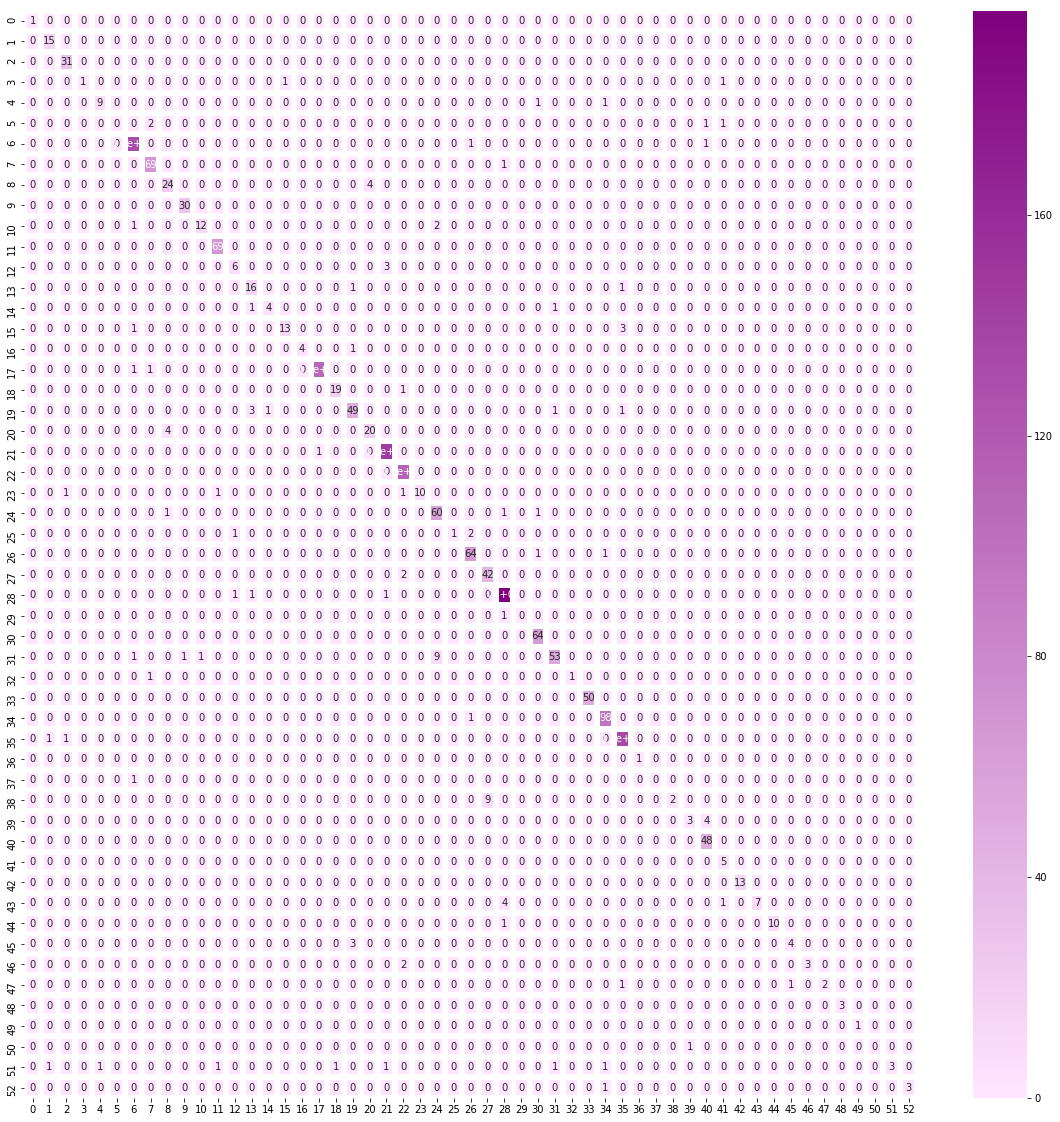

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = base_model.predict_classes(x_train)
y_original = np.argmax(y_train, axis=1)

cm = confusion_matrix(y_original, y_pred)
print('confusion matrix for {} features (base):'.format(cm.shape))
print(cm)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm, cmap=sns.light_palette('purple', n_colors=500, as_cmap=True), annot=True, linewidths = 5, ax=ax)

# DOT CLASS

In [19]:
y_train_dot = np_utils.to_categorical(dot_class)

In [20]:
dot_model = Sequential()

dot_model.add(Conv2D(16,(3,3),input_shape = (img_shape[0],img_shape[1],1),activation = 'relu'))
dot_model.add(Conv2D(16,(3,3),activation = 'relu'))
dot_model.add(MaxPooling2D())
dot_model.add(Conv2D(32,(3,3),activation = 'relu'))
dot_model.add(Conv2D(32,(3,3),activation = 'relu'))
dot_model.add(MaxPooling2D())
dot_model.add(Conv2D(64,(3,3),activation = 'relu'))
dot_model.add(Conv2D(64,(3,3),activation = 'relu'))
dot_model.add(MaxPooling2D())
dot_model.add(Flatten())
dot_model.add(Dense(64,activation = 'sigmoid'))
dot_model.add(Dropout(0.5))
dot_model.add(Dense(len(set(dot_class)),activation = 'softmax'))

dot_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

dot_model.fit(x_train,y_train_dot,epochs=20,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 566 samples
Epoch 1/20
1318/1318 [==============================] - 13s 10ms/step - loss: 0.4652 - categorical_accuracy: 0.8809 - val_loss: 0.2726 - val_categorical_accuracy: 0.9382
Epoch 2/20
1318/1318 [==============================] - 13s 10ms/step - loss: 0.4182 - categorical_accuracy: 0.9014 - val_loss: 0.2696 - val_categorical_accuracy: 0.9382
Epoch 3/20
1318/1318 [==============================] - 13s 10ms/step - loss: 0.3942 - categorical_accuracy: 0.9029 - val_loss: 0.2681 - val_categorical_accuracy: 0.9382
Epoch 4/20
1318/1318 [==============================] - 13s 10ms/step - loss: 0.3956 - categorical_accuracy: 0.9044 - val_loss: 0.2665 - val_categorical_accuracy: 0.9382
Epoch 5/20
1318/1318 [==============================] - 13s 10ms/step - loss: 0.3926 - categorical_accuracy: 0.9044 - val_loss: 0.2665 - val_categorical_accuracy: 0.9382
Epoch 6/20
1318/1318 [==============================] - 13s 10ms/step - loss: 0.3852 - categorical_accu

In [21]:
new_adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
dot_model.compile(optimizer=new_adam,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
dot_model.fit(x_train,y_train_dot,epochs=5,batch_size=64,validation_split=0.3)

Train on 1318 samples, validate on 566 samples
Epoch 1/5
1318/1318 [==============================] - 20s 15ms/step - loss: 0.3688 - categorical_accuracy: 0.9052 - val_loss: 0.2688 - val_categorical_accuracy: 0.9382
Epoch 2/5
1318/1318 [==============================] - 16s 12ms/step - loss: 0.3799 - categorical_accuracy: 0.9052 - val_loss: 0.2708 - val_categorical_accuracy: 0.9382
Epoch 3/5
1318/1318 [==============================] - 17s 13ms/step - loss: 0.3679 - categorical_accuracy: 0.9052 - val_loss: 0.2723 - val_categorical_accuracy: 0.9382
Epoch 4/5
1318/1318 [==============================] - 15s 11ms/step - loss: 0.3661 - categorical_accuracy: 0.9052 - val_loss: 0.2706 - val_categorical_accuracy: 0.9382
Epoch 5/5
1318/1318 [==============================] - 14s 11ms/step - loss: 0.3640 - categorical_accuracy: 0.9052 - val_loss: 0.2699 - val_categorical_accuracy: 0.9382


### confusion matrix:

1884/1884 [==============================] - 5s 3ms/step
confusion matrix for (3, 3) features (dot):
[[1724    0    0]
 [ 134    0    0]
 [  26    0    0]]


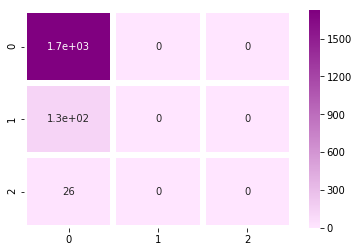

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = dot_model.predict_classes(x_train)
y_original = np.argmax(y_train_dot, axis=1)

cm = confusion_matrix(y_original, y_pred)
print('confusion matrix for {} features (dot):'.format(cm.shape))
print(cm)

#fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm, cmap=sns.light_palette('purple', n_colors=500, as_cmap=True), annot=True, linewidths = 5)

# MATRA CLASS

In [23]:
le_matra = LabelEncoder()
le_matra.fit(matra_class)
y_labeled_matra = le_matra.transform(matra_class)
y_train_matra = np_utils.to_categorical(y_labeled_matra)

print(y_train_matra.shape)

(1884, 16)


In [24]:
matra_model = Sequential()

matra_model.add(Conv2D(16,(3,3),input_shape = (img_shape[0],img_shape[1],1),activation = 'relu'))
matra_model.add(Conv2D(16,(3,3),activation = 'relu'))
matra_model.add(MaxPooling2D())
matra_model.add(Conv2D(32,(3,3),activation = 'relu'))
matra_model.add(Conv2D(32,(3,3),activation = 'relu'))
matra_model.add(MaxPooling2D())
matra_model.add(Conv2D(64,(3,3),activation = 'relu'))
matra_model.add(Conv2D(64,(3,3),activation = 'relu'))
matra_model.add(MaxPooling2D())
matra_model.add(MaxPooling2D())
matra_model.add(Dropout(0.5))
matra_model.add(Flatten())
matra_model.add(Dense(128,activation = 'sigmoid'))
matra_model.add(Dropout(0.25))
matra_model.add(Dense(len(set(matra_class)),activation = 'softmax'))

matra_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['categorical_accuracy'])

matra_model.fit(x_train,y_train_matra,epochs=45,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 566 samples
Epoch 1/45
1318/1318 [==============================] - 14s 11ms/step - loss: 0.1774 - categorical_accuracy: 0.4469 - val_loss: 0.1653 - val_categorical_accuracy: 0.4682
Epoch 2/45
1318/1318 [==============================] - 14s 11ms/step - loss: 0.1514 - categorical_accuracy: 0.5038 - val_loss: 0.1283 - val_categorical_accuracy: 0.5795
Epoch 3/45
1318/1318 [==============================] - 15s 11ms/step - loss: 0.1248 - categorical_accuracy: 0.5827 - val_loss: 0.1070 - val_categorical_accuracy: 0.6820
Epoch 4/45
1318/1318 [==============================] - 18s 13ms/step - loss: 0.1138 - categorical_accuracy: 0.6252 - val_loss: 0.0937 - val_categorical_accuracy: 0.7049
Epoch 5/45
1318/1318 [==============================] - 14s 11ms/step - loss: 0.1024 - categorical_accuracy: 0.6753 - val_loss: 0.1027 - val_categorical_accuracy: 0.6784
Epoch 6/45
1318/1318 [==============================] - 14s 11ms/step - loss: 0.0936 - categorical_accu

In [25]:
new_adam = keras.optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
matra_model.compile(optimizer=new_adam,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
matra_model.fit(x_train,y_train_matra,epochs=2,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 566 samples
Epoch 1/2
1318/1318 [==============================] - 15s 12ms/step - loss: 0.1543 - categorical_accuracy: 0.9598 - val_loss: 0.3516 - val_categorical_accuracy: 0.9170
Epoch 2/2
1318/1318 [==============================] - 15s 11ms/step - loss: 0.1228 - categorical_accuracy: 0.9659 - val_loss: 0.3665 - val_categorical_accuracy: 0.9205


### confusion matrix

1884/1884 [==============================] - 6s 3ms/step
confusion matrix for (16, 16) features (matra):
[[895   0   5   1   0   2   1   0   0   0   0   1   0   0   0   0]
 [  0   4   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0 286   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 180   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   2   1 136   0   0   0   0   0   2   0   0   0   0   0]
 [  5   0   0   0   0  37   0   0   0   0   0   0   0   0   0   0]
 [  7   0   1   0   0   0  20   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   2   0   0   0   0  81   0   0   0   0   0   0   0]
 [  0   0   0   3   0   0   0   0   0  79   0   4   0   0   0   0]
 [  0   1   0   0   5   0   0   0   2   0  47   1   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   3   1  54   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   

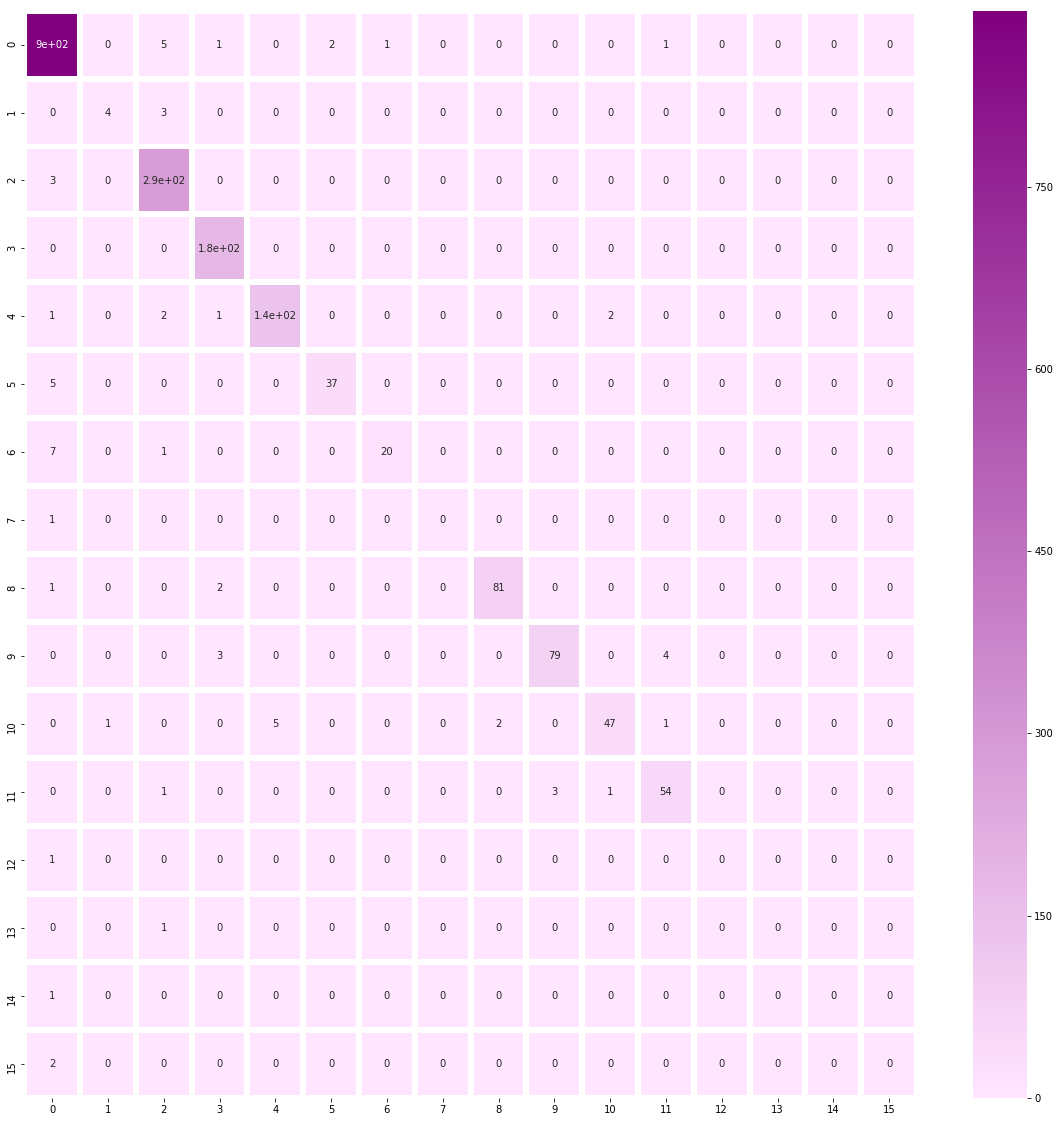

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = matra_model.predict_classes(x_train)
y_original = np.argmax(y_train_matra, axis=1)

cm = confusion_matrix(y_original, y_pred)
print('confusion matrix for {} features (matra):'.format(cm.shape))
print(cm)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm, cmap=sns.light_palette('purple', n_colors=500, as_cmap=True), annot=True, linewidths = 5, ax=ax)

# Dumping Models to Disk

In [27]:
dot_model.save('models/dot_model4w.model')
matra_model.save('models/matra_model4w.model')
base_model.save('models/base_model4w.model')

In [28]:
from keras.models import load_model

dot_model2 = load_model('models/dot_model4k.model')
matra_model2 = load_model('models/matra_model4k.model')
base_model2 = load_model('models/base_model4k.model')



# Half Characters